<a href="https://colab.research.google.com/github/rsabilio/ia024-projeto-rag/blob/main/2_rag_bm25.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Baseline

* Usar segmentação de sentenças em janelas
* BM25 como buscador

# Instalando pacotes

In [1]:
!pip install -q llama-index llama-index-llms-groq llama-index-retrievers-bm25

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.4/15.4 MB 43.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 44.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.8/130.8 kB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 327.4/327.4 kB 21.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 28.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 290.4/290.4 kB 19.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.2/49.2 kB 2.5 MB/s eta 0:00:00


# Importando pacotes

In [2]:
import os
from google.colab import userdata

os.environ['GROQ_API_KEY'] = userdata.get('GROQ_API_KEY_IFSP')

In [3]:
import json
import time
import random
from tqdm import tqdm
from rich.pretty import pprint
import glob

from llama_index.core import Document, Settings, PromptTemplate
from llama_index.core.node_parser import SentenceWindowNodeParser
from llama_index.retrievers.bm25 import BM25Retriever
from llama_index.core.query_engine import RetrieverQueryEngine
from llama_index.core.postprocessor import MetadataReplacementPostProcessor
from llama_index.llms.groq import Groq
from llama_index.core.response.notebook_utils import display_source_node, display_response
from llama_index.core.evaluation import FaithfulnessEvaluator, CorrectnessEvaluator, RelevancyEvaluator

import nest_asyncio
nest_asyncio.apply()

from IPython.display import Markdown, display
import pandas as pd

In [4]:
Settings.llm = Groq(model="llama3-70b-8192")


# GitHub

In [5]:
GITHUB_TOKEN      = userdata.get('GITHUB_TOKEN')
GITHUB_USER_EMAIL = userdata.get('GITHUB_USER_EMAIL')
GITHUB_USER_NAME  = userdata.get('GITHUB_USER_NAME')

!git config --global user.email '''{GITHUB_USER_EMAIL}'''
!git config --global user.name '''{GITHUB_USER_NAME}'''

# Clonar o repositório GitHub
!git clone https://{GITHUB_TOKEN}@github.com/rsabilio/ia024-projeto-rag.git

Cloning into 'ia024-projeto-rag'...
remote: Enumerating objects: 8663, done.
remote: Counting objects: 100% (212/212), done.
remote: Compressing objects: 100% (67/67), done.
remote: Total 8663 (delta 146), reused 209 (delta 145), pack-reused 8451
Receiving objects: 100% (8663/8663), 1.27 GiB | 27.02 MiB/s, done.
Resolving deltas: 100% (3667/3667), done.
Updating files: 100% (5813/5813), done.
Filtering content: 100% (1211/1211), 140.28 MiB | 14.71 MiB/s, done.


In [6]:
DATA_DIR = '/content/ia024-projeto-rag'

In [7]:
def save_on_git(msg):

    %cd /content/ia024-projeto-rag

    !git remote set-url origin https://{GITHUB_TOKEN}@github.com/rsabilio/ia024-projeto-rag

    !git pull origin main

    !git add .

    !git commit -m '''{msg}'''

    !git push origin main

In [8]:
def update_local_repo():
    %cd /content/ia024-projeto-rag

    !git remote set-url origin https://{GITHUB_TOKEN}@github.com/rsabilio/ia024-projeto-rag

    !git pull origin main

# Carregando documentos e criando os nós

In [9]:
def get_json_files(directory, pattern="*.json"):
    return glob.glob(os.path.join(directory, pattern))

base_docs     = []

print(f"Carregando Estatuto e Organizações Didáticas...")
directory_path = f"{DATA_DIR}/2-dataset/"
json_files     = get_json_files(directory_path, pattern="*-nivel-subsecao.json")

for json_file in json_files:

    print(f"Carregando: {json_file}")
    with open(json_file, 'r') as f:
        documento = json.load(f)

    documento_titulo = documento['titulo']

    for parte in documento['partes']:
        metadata = {}
        metadata["documento"] = documento_titulo
        metadata["titulo"]    = ""
        metadata["capitulo"]  = ""
        metadata["seção"]     = ""
        metadata["subseção"]  = ""

        titulo_nome    = parte['titulo_nome']
        titulo_artigos = parte['titulo_artigos']
        capitulos      = parte['capitulos']

        metadata["titulo"] = titulo_nome
        if len(titulo_artigos) > 0:
            for artigo in titulo_artigos:
                node = Document(text=artigo, metadata=metadata)
                base_docs.append(node)

        if len(capitulos) == 0:
            continue

        for capitulo in capitulos:
            cap_titulo  = capitulo['capitulo_nome']
            cap_artigos = capitulo['capitulo_artigos']

            metadata["capitulo"] = cap_titulo
            metadata["seção"]     = ""
            metadata["subseção"]  = ""
            for artigo in cap_artigos:
                node = Document(text=artigo, metadata=metadata)
                base_docs.append(node)

            if len(capitulo['secoes']) == 0:
                continue

            for secao in capitulo['secoes']:
                secao_titulo  = secao['secao_nome']
                secao_artigos = secao['secao_artigos']

                metadata["seção"] = secao_titulo
                for artigo in secao_artigos:
                    node = Document(text=artigo, metadata=metadata)
                    base_docs.append(node)

                if len(secao['subsecoes']) == 0:
                    continue

                for subsecao in secao['subsecoes']:
                    subsecao_titulo  = subsecao['subsecao_nome']
                    subsecao_artigos = subsecao['subsecao_artigos']

                    metadata["subseção"] = subsecao_titulo
                    for artigo in subsecao_artigos:
                        node = Document(text=artigo, metadata=metadata)
                        base_docs.append(node)

    print(f"{len(base_docs)} nodes carregados")

print(f"Carregando portarias: {directory_path}")
directory_path = f"{DATA_DIR}/2-dataset/2-boituva/portarias"
json_files     = get_json_files(directory_path)

for json_file in json_files:
    print(f"Carregando: {json_file}")
    with open(json_file, 'r') as f:
        documento = json.load(f)

    for portaria in documento:

        portaria_titulo = portaria['titulo']
        portaria_inicio = portaria['inicio']
        portaria_fim    = portaria['fim']


        metadata = {}
        metadata["documento"] = portaria_titulo

        node = Document(text=portaria_inicio, metadata=metadata)
        base_docs.append(node)

        for artigo in portaria['artigos']:
            node = Document(text=artigo, metadata=metadata)
            base_docs.append(node)

        if portaria['fim'] != "":
            node = Document(text=portaria_fim, metadata=metadata)
            base_docs.append(node)

    print(f"{len(base_docs)} documentos carregados")

for i, doc in enumerate(base_docs):
    doc.id_ = f"doc_{i}"

print(f"Total de documentos carregados: {len(base_docs)}")

Carregando Estatuto e Organizações Didáticas...
Carregando: /content/ia024-projeto-rag/2-dataset/estatuto-nivel-subsecao.json
50 nodes carregados
Carregando: /content/ia024-projeto-rag/2-dataset/organização_didática_da_educação_básica-nivel-subsecao.json
290 nodes carregados
Carregando: /content/ia024-projeto-rag/2-dataset/organização_didática_dos_cursos_de_graduação-nivel-subsecao.json
494 nodes carregados
Carregando portarias: /content/ia024-projeto-rag/2-dataset/
Carregando: /content/ia024-projeto-rag/2-dataset/2-boituva/portarias/boituva-2020.json
547 documentos carregados
Carregando: /content/ia024-projeto-rag/2-dataset/2-boituva/portarias/boituva-2014.json
679 documentos carregados
Carregando: /content/ia024-projeto-rag/2-dataset/2-boituva/portarias/boituva-2015.json
682 documentos carregados
Carregando: /content/ia024-projeto-rag/2-dataset/2-boituva/portarias/boituva-2024.json
847 documentos carregados
Carregando: /content/ia024-projeto-rag/2-dataset/2-boituva/portarias/boituva-

In [10]:
pprint(base_docs[0])

Document(
│   id_='doc_0',
│   embedding=None,
│   metadata={
│   │   'documento': 'Estatuto',
│   │   'titulo': 'TÍTULO I - DA INSTITUIÇÃO',
│   │   'capitulo': 'CAPÍTULO I DA NATUREZA E DAS FINALIDADES.',
│   │   'seção': '',
│   │   'subseção': ''
│   },
│   excluded_embed_metadata_keys=[],
│   excluded_llm_metadata_keys=[],
│   relationships={},
│   text='Art 1º - O INSTITUTO FEDERAL DE EDUCAÇÃO, CIÊNCIA E TECNOLOGIA DE SÃO PAULO – IFSP, com sede e foro na cidade de São Paulo, criado nos termos da Lei nº. 11.892, de 29 de dezembro de 2008, constitui-se em autarquia federal, vinculada ao Ministério da Educação, detentora de autonomia administrativa, patrimonial, financeira, didático-pedagógica e disciplinar. §1º- O IFSP é domiciliado na sede de sua Reitoria, situada na Rua Pedro Vicente, 625, Canindé, São Paulo. §2º- O IFSP é uma instituição de educação superior, básica e profissional, pluricurricular e multicampi, especializada na oferta de educação profissional e tecnológica nas diferentes modalidades de ensino, com base na conjugação de conhecimentos técnicos e tecnológicos com a sua prática pedagógica, nos termos da lei. Tem como sedes, para os fins da legislação educacional: I - Reitoria, no endereço citado no §1º. II - Campus São Paulo, situado na Rua Pedro Vicente, 625, Canindé, São Paulo. III - Campus Cubatão, situado na Rua Maria Cristina, 50, Jardim Casqueiro, Cubatão. IV - Campus Sertãozinho, situado na Rua Américo Ambrósio, 269, Jardim Canaã, Sertãozinho. V - Campus Guarulhos, situado na Avenida Salgado Filho, 2501, Bairro Vila Rio de Janeiro, Guarulhos. VI - Campus São João da Boa Vista, situado no Acesso Dr. João Batista Merlin, s/ nº, Jardim Itália, São João da Boa Vista. VII - Campus Caraguatatuba, situado na Avenida Rio Grande do Norte, 450, Indaiá, Caraguatatuba. VIII - Campus Bragança Paulista, situado na Avenida Francisco Samuel Lucchesi Filho, 770, Penha, Bragança Paulista. IX - Campus Salto, situado na Rua Rio Branco, 1780, Vila Teixeira, Salto. X - Campus São Roque, situado na Rodovia Quintino de Lima, 2100, Jardim Conceição, São Roque. XI - Campus São Carlos, situado na Rodovia Washington Luís, km 235 AT-6, Sala 119, São Carlos. XII - Campus Campos do Jordão, situado na Rua Monsenhor José Vita, 280, Vila Abernéssia, Campos do Jordão. XIII - Campus Barretos, situado na Avenida C-1, Bairro Ide Daher, Barretos. XIV - Campus Suzano, situado na Avenida Mogi das Cruzes, 1.501, Parque Suzano, Suzano. XV - Campus Campinas, situado na Rodovia D - Pedro I – SP 65 – KM 143,6, Amarais, Campinas; XVI - Campus Catanduva, situado na Avenida Imperatriz, s/ nº, Distrito Industrial, Catanduva. XVII - Campus Avaré, situado na Avenida Professor Celso Ferreira da Silva, s/ nº, Jardim Europa, Avaré. XVIII - Campus Araraquara, situado no Ramal de Acesso Engenheiro Heitor de Souza Pinheiro, Araraquara. XIX - Campus Itapetininga, situado na Avenida João Olímpio de Oliveira, Bairro Assen, Itapetininga. XX - Campus Birigui, situado na Rua Pedro Cavalo, 709, Residencial Portal da Pérola II, Birigui. XXI - Campus Votuporanga, situado na Rua Pará, s/ nº, Chácara Aviação, Votuporanga. XXII - Campus Registro, situado na Rua Clara Gianotti de Souza, 5.180, Agrochá, Registro. XXIII - Campus Presidente Epitácio, situado na Rua Rua José Ramos Júnior, nº 27-50, Jardim Tropical, Presidente Epitácio. XXIV - Campus Piracicaba, situado na Rodovia Deputado Laércio Corte, s/ nº, Bairro Santa Rosa, Piracicaba. XXV - Campus Hortolândia, situado na Rodovia Municipal TeodorCondiev, 1896, Hortolândia. XXVI - Campus Boituva, situado na Avenida Zélia de Lima Rosa, nº 100, Portal dos Pássaros, Boituva. XXVII - Campus Capivari, situado na Avenida Ênio Pires de Camargo, 2971, São João Batista, Capivari. XXVIII - Campus Matão, situado na Rua José Bonifácio, 1176, Centro, Matão. XXIX - Campus São José dos Campos, situado na Rodovia Presidente Dutra s/n – km 145, Jardim Diamante, São José dos Campos. XXXI - Núcleo Avançado de Assis, situado na Avenida Get

In [11]:
# Esta classe separa o texto em sentenças e, de acordo com o parâmetro "window_size",
# cria janelas com a sentença atual mais 'window_size' sentenças antes e depois
# as janelas são salvas no metadata "window" e as sentenças em "original_sentence"
node_parser = SentenceWindowNodeParser.from_defaults(
    window_size=1, # com valor 1, as "janelas" terão tamanho 3: uma sentença antes, a sentença atual, uma sentença depois
    window_metadata_key="window",
    original_text_metadata_key="original_sentence",
)

nodes = node_parser.get_nodes_from_documents(base_docs)
len(nodes)

4672

In [ ]:
pprint(nodes[0])

# Criando BM25

In [12]:
# Criando o BM25
# com 'tokenizer=None', ele vai fazer a remoção de stop words e o stemming
retriever = BM25Retriever(nodes=nodes, tokenizer=None, similarity_top_k=10)

In [13]:
# Testando a busca com BM25
retriever_nodes = retriever.retrieve("Qual o nome do IFSP?")
for node in retriever_nodes:
    display_source_node(node)

**Node ID:** b460f6a5-1967-47a9-b13d-b04c7bda372a<br>**Similarity:** 1.6530010535409605<br>**Text:** CANCELAMENTO DE MATRÍCULA - É o ato formal pelo qual o estudante se desliga do IFSP.<br>

**Node ID:** 8f30a4dc-0135-444f-81cc-055da90d33dd<br>**Similarity:** 0.0<br>**Text:** Em todos os casos, deverá ser estabelecido termo de acordo ou convênio do IFSP com a instituição ...<br>

**Node ID:** 9aac9439-861f-4fb7-a20b-02efe3e8b5e6<br>**Similarity:** 1.8862781864324674<br>**Text:** Em todos os casos, deverá ser estabelecido termo de acordo ou convênio do IFSP com a instituição ...<br>

**Node ID:** 855f06b2-3fda-4738-9ab7-48b932c71135<br>**Similarity:** 1.3474862815615087<br>**Text:** Art 159 - As informações acadêmicas dos discentes do IFSP são armazenadas em prontuário, o qual f...<br>

**Node ID:** 74607a42-f969-4fc2-8c69-a56bb5518fa1<br>**Similarity:** 0.0<br>**Text:** Para efeito de registro acadêmico, constará no histórico escolar o nome da disciplina constante n...<br>

**Node ID:** 9067f3e2-a484-4c6e-9a3b-1a3f187b0f0b<br>**Similarity:** 0.0<br>**Text:** Art 1º - ALTERA o nome de Centro Federal de Línguas do Câmpus Boituva (CeFeL) para Centro de Líng...<br>

**Node ID:** c8088890-7717-4fd7-88d9-f8cacc3dc0fc<br>**Similarity:** 0.0<br>**Text:** Artigo 29 Cada eleitor devera assinalar um nome de candidato na cedula de votacao.<br>

**Node ID:** f28c1de5-2df0-4afb-843a-0f8dbf82a5c3<br>**Similarity:** 0.0<br>**Text:** Altera o nome e Designa Servidora como Responsável pelo Centro de Línguas – CeLin, do Câmpus Boit...<br>

**Node ID:** 5e9931f3-4f68-44eb-89aa-77e97630c431<br>**Similarity:** 0.0<br>**Text:** §8º- Os procedimentos de trabalho do Conselho Superior serão disciplinados no seu regulamento o q...<br>

**Node ID:** 85b7bbc3-41a9-45da-8a68-b803f3b9d254<br>**Similarity:** 0.0<br>**Text:** Art 52 - Matrícula é o ato formal pelo qual se dá a vinculação acadêmica do estudante ao IFSP apó...<br>

# Criando o 'motor de busca'

In [14]:
# Após testes e análise do código, percebi que:
# - O BM25 faz a busca utilizando a sentença e não a janela
# - O resultado da busca é substituído pelas respectivas "janelas"
# - O LLM indicado é utilizado para "sintetizar" o conteúdo das janelas
query_engine = RetrieverQueryEngine.from_args(
    retriever=retriever,
    node_postprocessors=[
        MetadataReplacementPostProcessor(target_metadata_key="window")
    ]
)

In [15]:
def display_prompt_dict(prompts_dict):
    for k, p in prompts_dict.items():
        text_md = f"**Prompt Key**: {k} " f"\n\n**Text:** "
        display(Markdown(text_md))
        print(p.get_template())
        display(Markdown(""))


display_prompt_dict(query_engine.get_prompts())

**Prompt Key**: response_synthesizer:text_qa_template 

**Text:** 

Context information is below.
---------------------
{context_str}
---------------------
Given the context information and not prior knowledge, answer the query.
Query: {query_str}
Answer: 


**Prompt Key**: response_synthesizer:refine_template 

**Text:** 

The original query is as follows: {query_str}
We have provided an existing answer: {existing_answer}
We have the opportunity to refine the existing answer (only if needed) with some more context below.
------------
{context_msg}
------------
Given the new context, refine the original answer to better answer the query. If the context isn't useful, return the original answer.
Refined Answer: 


In [17]:
new_summary_tmpl_str = ("""
Context information is below.
---------------------
{context_str}
---------------------
Given the context information and not prior knowledge, answer the query.
If you have an answer, provide the source, such as the document, title, chapter, or article when available.
Otherwise, just leave the source field blank.
It is important that you use the same language as the query.
Query: {query_str}
Source:
Answer:
"""
)

new_refine_tmpl_str = ("""
The original query is as follows: {query_str}
We have provided an existing answer: {existing_answer}
We have the opportunity to refine the existing answer (only if needed) with some more context below.
------------
{context_msg}
------------
Given the new context, refine the original answer to better answer the query. If the context isn't useful, return the original answer.
Do not add other information, such as 'The refined answer remains the same' or 'Justification', besides the answer and the source.
If you have an answer, provide the source, such as the document, title, chapter, or article when available.
Otherwise, just leave the source field blank.
It is important that you use the same language as the query.

Refined Answer:

"""
)

new_summary_tmpl = PromptTemplate(new_summary_tmpl_str)
new_refine_tmpl_str = PromptTemplate(new_refine_tmpl_str)

query_engine.update_prompts(
    {"response_synthesizer:text_qa_template": new_summary_tmpl
     , "response_synthesizer:refine_template" : new_refine_tmpl_str}
)

display_prompt_dict(query_engine.get_prompts())


**Prompt Key**: response_synthesizer:text_qa_template 

**Text:** 


Context information is below.
---------------------
{context_str}
---------------------
Given the context information and not prior knowledge, answer the query.
If you have an answer, provide the source, such as the document, title, chapter, or article when available.
Otherwise, just leave the source field blank.
It is important that you use the same language as the query.
Query: {query_str}
Source:
Answer:



**Prompt Key**: response_synthesizer:refine_template 

**Text:** 


The original query is as follows: {query_str}
We have provided an existing answer: {existing_answer}
We have the opportunity to refine the existing answer (only if needed) with some more context below.
------------
{context_msg}
------------
Given the new context, refine the original answer to better answer the query. If the context isn't useful, return the original answer.
Do not add other information, such as 'The refined answer remains the same' or 'Justification', besides the answer and the source.
If you have an answer, provide the source, such as the document, title, chapter, or article when available.
Otherwise, just leave the source field blank.
It is important that you use the same language as the query.

Refined Answer:




In [18]:
#query = "Qual o nome do IFSP?"
#query = "Quais são os campi do IFSP? Além de responder à pergunta, informe o documento, o Capítulo e o Artigo de referência."
#query = "Quantos campi o IFSP tem? Informe onde você encontrou essa informação"
#query = "O IFSP tem só ensino médio? Além de responder à pergunta, informe o documento, o Capítulo e o Artigo de referência."
#query = "Quais artigos do Estatuto dizem que o IFSP oferece mestrado e doutorado?"
#query = "O que diz o Art 6º do estatuto do IFSP?"
#query = "O Art 4º do estatuto do IFSP é sobre o que?"

query = "Sou aluno de graduação e gostaria de saber o que são as transferências especial e ex oficio."
#query = "O que é Estudante Especial?"
#query = "Em qual portaria Ramon Abilio foi designado para compor a Comissão de Avaliação de Atividades Docentes - CAAD?"

# Testando a busca
response = query_engine.query(query)
display_response(response)

**`Final Response:`** Answer: As transferências especiais ou ex-officio são mudanças de um estudante para outra instituição, no mesmo curso ou em curso de área afim (quando a instituição de destino não tiver o mesmo curso da instituição de origem), de funcionário público civil ou militar (dele próprio, de seu cônjuge ou filhos) transferido, a serviço, para outro estado ou município.

Source: Organização Didática dos Cursos de Graduação, TÍTULO VII DAS DISPOSIÇÕES GERAIS E FINAIS, Glossário.

In [ ]:
for node in response.source_nodes:
    display_source_node(node, source_length=500)

# Avaliando

In [19]:
def get_contexts(response):
    contexts = []
    for node in response.source_nodes:
        metadata = ', '.join(node.metadata.values())
        context  = node.get_content()
        contexts.append(f"Fonte: {metadata} # Contextos: {context};")
    return '\n'.join(contexts)

In [20]:
df = pd.read_csv(f"{DATA_DIR}/3-questions_answers/test_dataset_100.csv")
df

,question,answer,context,reference,document
0,Quem são os servidores designados para constit...,"Fernando Vernal Salina Giorjety Licorini Dias,...","Art 20 - DESIGNAR, os servidores abaixo relaci...","Portaria nº 1.324, de 26 de março de 2014, Art...",boituva_portarias
1,O que é mobilidade de estudantes no IFSP?,A mobilidade de estudantes é a possibilidade d...,Art 199 - A mobilidade de estudantes poderá se...,"Organização Didática da Educação Básica, Títul...",od_edu_basica
2,Quais são os membros designados para compor a ...,"Jaime Martimiano Junior, Cristiane Vega Parise...",Art 1º - Altera em partes a PORTARIA BTV.0080/...,"PORTARIA BTV.0080/2018, de 06 de julho de 2018...",boituva_portarias
3,Quem são os membros designados para compor a C...,"Os membros designados são Felipe Gobo Bruno, M...","Art 1º - DESIGNAR, os membros abaixo relaciona...","PORTARIA BTV.0057/2020, DE 23 DE JULHO DE 2020...",boituva_portarias
4,Quais são os objetivos do Estágio Profissional...,Os objetivos do Estágio Profissional Supervisi...,Art 144 - São objetivos do estágio supervision...,"Organização Didática da Educação Básica, Títul...",od_edu_basica
...,...,...,...,...,...
95,Quem é o responsável pela coordenação do Comit...,A coordenação do Comitê é responsável por orga...,Art 2º - Ficará a cargo da Coordenação do Comi...,"Portaria nº 3.903, de 04 de novembro de 2015, ...",boituva_portarias
96,Quem é o servidor designado para desempenhar a...,"Ricardo José Correa, Advogado, matrícula SIAPE...",A PRESIDENTE DA COMISSÃO DE PROCESSO ADMINISTR...,"Portaria nº 1.970, de 28 de junho de 2018, Art...",boituva_portarias
97,Quais são os membros da Comissão de Elaboração...,Os membros da Comissão são: JAIR MANOEL CASQUE...,"Art 2.º - DESIGNAR, os servidores abaixo relac...","PORTARIA BTV.0060/2020, DE 24 DE JULHO DE 2020...",boituva_portarias
98,Quem é o responsável pela designação de servid...,O Diretor Geral do Campus Boituva do Instituto...,"O DIRETOR GERAL DO CAMPUS BOITUVA, DO INSTITUT...","PORTARIA BTV.0062/2018, DE 18 DE JUNHO DE 2018...",boituva_portarias


In [28]:


df_result[34:]

,question,answer,context,reference,document,rag_answer,rag_contexts,faithfulness,relevancy,correctness,correctness_feedback
34,Quem é o responsável pela Portaria BTV.0011/2018?,O Diretor-Geral em exercício do Instituto Fede...,DIRETOR-GERAL EM EXERCiCIO DOE TECNOLOGIADE SA...,"Portaria BTV.0011/2018, de 20 de fevereiro de ...",boituva_portarias,There is no Portaria BTV.0011/2018 in the prov...,Fonte: Art 3º - Revogar a PORTARIA BTV.0011/20...,1.0,0.0,1.0,The generated answer is not relevant to the us...
35,Quais são os membros designados para compor o ...,Os membros designados para compor o NAPNE do C...,Art 5° DESIGNAR os membros abaixo relacionados...,"PORTARIA BTV.0103/2018, DE 04 DE SETEMBRO DE 2...",boituva_portarias,NaN,NaN,NaN,NaN,NaN,NaN
36,Quem é o responsável pela substituição do Dire...,"O servidor Flávio Aparecido Pontes, ocupante d...","RESOLVE: DESIGNAR, servidor FLÁVIO APARECIDO P...","Portaria nº 3.903, de 04 de novembro de 2015, ...",boituva_portarias,NaN,NaN,NaN,NaN,NaN,NaN
37,Quais são as modalidades de prática profission...,As modalidades de prática profissional no IFSP...,Art 148 - A prática profissional será realizad...,"Organização Didática dos Cursos de Graduação, ...",od_graduacao,NaN,NaN,NaN,NaN,NaN,NaN
38,"Quem é o responsável pela Portaria nº 3.903, d...",O Ministério da Educação,MINISTÉRIO DA EDUCAÇÃO INSTITUTO FEDERAL DE ED...,"Portaria nº 3.903, de 04 de novembro de 2015, ...",boituva_portarias,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
95,Quem é o responsável pela coordenação do Comit...,A coordenação do Comitê é responsável por orga...,Art 2º - Ficará a cargo da Coordenação do Comi...,"Portaria nº 3.903, de 04 de novembro de 2015, ...",boituva_portarias,NaN,NaN,NaN,NaN,NaN,NaN
96,Quem é o servidor designado para desempenhar a...,"Ricardo José Correa, Advogado, matrícula SIAPE...",A PRESIDENTE DA COMISSÃO DE PROCESSO ADMINISTR...,"Portaria nº 1.970, de 28 de junho de 2018, Art...",boituva_portarias,NaN,NaN,NaN,NaN,NaN,NaN
97,Quais são os membros da Comissão de Elaboração...,Os membros da Comissão são: JAIR MANOEL CASQUE...,"Art 2.º - DESIGNAR, os servidores abaixo relac...","PORTARIA BTV.0060/2020, DE 24 DE JULHO DE 2020...",boituva_portarias,NaN,NaN,NaN,NaN,NaN,NaN
98,Quem é o responsável pela designação de servid...,O Diretor Geral do Campus Boituva do Instituto...,"O DIRETOR GERAL DO CAMPUS BOITUVA, DO INSTITUT...","PORTARIA BTV.0062/2018, DE 18 DE JUNHO DE 2018...",boituva_portarias,NaN,NaN,NaN,NaN,NaN,NaN


In [25]:
indexes_not_nan = df_result[df_result['faithfulness'].notna()].index

# Converter para lista
indexes_not_nan_list = indexes_not_nan.tolist()
indexes_not_nan_list

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34]

In [30]:
import pickle
if os.path.exists(f"{DATA_DIR}/5-evaluations/df_result-bm25-2.pkl"):
    with open(f"{DATA_DIR}/5-evaluations/df_result-bm25-2.pkl", 'rb') as f:
        df_result = pickle.load(f)
else:
    df_result = df.copy()

faith_evaluator     = FaithfulnessEvaluator()
relevancy_evaluator = RelevancyEvaluator()
correct_evaluator   = CorrectnessEvaluator()
data = []

for index, row in df_result[35:].iterrows():
    print(f"Processando amostra: {index}")

    result       = {}
    query        = row['question']
    ground_truth = f"{row['answer']} \nFonte: {row['reference']}"

    # Fazendo consulta
    response                            = query_engine.query(query)
    df_result.at[index, 'rag_answer']   = response.response
    df_result.at[index, 'rag_contexts'] = get_contexts(response)


    # Avaliando Faithfulness
    eval_result                         = faith_evaluator.evaluate_response(response=response)
    df_result.at[index, 'faithfulness'] = eval_result.score


    # Avaliando Relevancy
    eval_result                      = relevancy_evaluator.evaluate_response(query=query, response=response)
    df_result.at[index, 'relevancy'] = eval_result.score


    # Avaliando Correctness
    eval_result = correct_evaluator.evaluate(
        query=query,
        response=response.response,
        reference=ground_truth,
    )
    df_result.at[index, 'correctness']          = eval_result.score
    df_result.at[index, 'correctness_feedback'] = eval_result.feedback

    df_result.to_pickle(f"{DATA_DIR}/5-evaluations/df_result-bm25-2.pkl")

    if index % 2 == 0:
        save_on_git(f"Salvamento parcial do resultado da avaliação do BM25. Amostra: {index}")


df_result

Processando amostra: 35
Processando amostra: 36
/content/ia024-projeto-rag
From https://github.com/rsabilio/ia024-projeto-rag
 * branch            main       -> FETCH_HEAD
Already up to date.
[main c21d886] Salvamento parcial do resultado da avaliação do BM25. Amostra: 36
 1 file changed, 0 insertions(+), 0 deletions(-)
 rewrite 5-evaluations/df_result-bm25-2.pkl (86%)
Enumerating objects: 7, done.
Counting objects: 100% (7/7), done.
Delta compression using up to 2 threads
Compressing objects: 100% (4/4), done.
Writing objects: 100% (4/4), 3.19 KiB | 815.00 KiB/s, done.
Total 4 (delta 2), reused 0 (delta 0), pack-reused 0
remote: Resolving deltas: 100% (2/2), completed with 2 local objects.
To https://github.com/rsabilio/ia024-projeto-rag
   7186732..c21d886  main -> main
Processando amostra: 37


Processando amostra: 38
/content/ia024-projeto-rag
From https://github.com/rsabilio/ia024-projeto-rag
 * branch            main       -> FETCH_HEAD
Already up to date.
[main d4922f8] Salvamento parcial do resultado da avaliação do BM25. Amostra: 38
 1 file changed, 0 insertions(+), 0 deletions(-)
Enumerating objects: 7, done.
Counting objects: 100% (7/7), done.
Delta compression using up to 2 threads
Compressing objects: 100% (4/4), done.
Writing objects: 100% (4/4), 3.25 KiB | 1.08 MiB/s, done.
Total 4 (delta 2), reused 0 (delta 0), pack-reused 0
remote: Resolving deltas: 100% (2/2), completed with 2 local objects.
To https://github.com/rsabilio/ia024-projeto-rag
   c21d886..d4922f8  main -> main
Processando amostra: 39
Processando amostra: 40
/content/ia024-projeto-rag
From https://github.com/rsabilio/ia024-projeto-rag
 * branch            main       -> FETCH_HEAD
Already up to date.
[main 0720d54] Salvamento parcial do resultado da avaliação do BM25. Amostra: 40
 1 file changed, 0 i

,question,answer,context,reference,document,rag_answer,rag_contexts,faithfulness,relevancy,correctness,correctness_feedback
0,Quem são os servidores designados para constit...,"Fernando Vernal Salina Giorjety Licorini Dias,...","Art 20 - DESIGNAR, os servidores abaixo relaci...","Portaria nº 1.324, de 26 de março de 2014, Art...",boituva_portarias,NaN,NaN,NaN,NaN,NaN,NaN
1,O que é mobilidade de estudantes no IFSP?,A mobilidade de estudantes é a possibilidade d...,Art 199 - A mobilidade de estudantes poderá se...,"Organização Didática da Educação Básica, Títul...",od_edu_basica,NaN,NaN,NaN,NaN,NaN,NaN
2,Quais são os membros designados para compor a ...,"Jaime Martimiano Junior, Cristiane Vega Parise...",Art 1º - Altera em partes a PORTARIA BTV.0080/...,"PORTARIA BTV.0080/2018, de 06 de julho de 2018...",boituva_portarias,NaN,NaN,NaN,NaN,NaN,NaN
3,Quem são os membros designados para compor a C...,"Os membros designados são Felipe Gobo Bruno, M...","Art 1º - DESIGNAR, os membros abaixo relaciona...","PORTARIA BTV.0057/2020, DE 23 DE JULHO DE 2020...",boituva_portarias,NaN,NaN,NaN,NaN,NaN,NaN
4,Quais são os objetivos do Estágio Profissional...,Os objetivos do Estágio Profissional Supervisi...,Art 144 - São objetivos do estágio supervision...,"Organização Didática da Educação Básica, Títul...",od_edu_basica,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
95,Quem é o responsável pela coordenação do Comit...,A coordenação do Comitê é responsável por orga...,Art 2º - Ficará a cargo da Coordenação do Comi...,"Portaria nº 3.903, de 04 de novembro de 2015, ...",boituva_portarias,O responsável pela coordenação do Comitê de Pe...,"Fonte: Art 1º - DESIGNAR, os servidores abaixo...",1.0,1.0,4.0,The generated answer is relevant to the user q...
96,Quem é o servidor designado para desempenhar a...,"Ricardo José Correa, Advogado, matrícula SIAPE...",A PRESIDENTE DA COMISSÃO DE PROCESSO ADMINISTR...,"Portaria nº 1.970, de 28 de junho de 2018, Art...",boituva_portarias,The query is asking about a specific designati...,Fonte: MINISTERIO DA EDUCACAO\n\n INSTITUTO F...,0.0,0.0,1.0,The generated answer is not relevant to the us...
97,Quais são os membros da Comissão de Elaboração...,Os membros da Comissão são: JAIR MANOEL CASQUE...,"Art 2.º - DESIGNAR, os servidores abaixo relac...","PORTARIA BTV.0060/2020, DE 24 DE JULHO DE 2020...",boituva_portarias,Os membros da Comissão de Elaboração e Impleme...,"Fonte: Art 2º - INSTITUIR, a Comissão de Elabo...",1.0,1.0,4.0,The generated answer is relevant to the user q...
98,Quem é o responsável pela designação de servid...,O Diretor Geral do Campus Boituva do Instituto...,"O DIRETOR GERAL DO CAMPUS BOITUVA, DO INSTITUT...","PORTARIA BTV.0062/2018, DE 18 DE JUNHO DE 2018...",boituva_portarias,O responsável pela designação de servidores pa...,Fonte: MINISTÉRIO DA EDUCAÇÃO INSTITUTO FEDER...,1.0,1.0,4.5,The generated answer is almost identical to th...


In [32]:
with open(f"{DATA_DIR}/5-evaluations/df_result-bm25-1.pkl", 'rb') as f:
    df_result_1 = pickle.load(f)

df_result_1

,question,answer,context,reference,document,rag_answer,rag_contexts,faithfulness,relevancy,correctness,correctness_feedback
0,Quem são os servidores designados para constit...,"Fernando Vernal Salina Giorjety Licorini Dias,...","Art 20 - DESIGNAR, os servidores abaixo relaci...","Portaria nº 1.324, de 26 de março de 2014, Art...",boituva_portarias,Os servidores designados para constituírem o N...,"Fonte: Art: 20 DESIGNAR, os servidores abaixo ...",1.0,1.0,5.0,The generated answer is fully correct and rele...
1,O que é mobilidade de estudantes no IFSP?,A mobilidade de estudantes é a possibilidade d...,Art 199 - A mobilidade de estudantes poderá se...,"Organização Didática da Educação Básica, Títul...",od_edu_basica,Query: O que é mobilidade de estudantes no IFS...,Fonte: Art 80 - A mobilidade de estudantes pod...,1.0,1.0,4.5,The generated answer is highly relevant to the...
2,Quais são os membros designados para compor a ...,"Jaime Martimiano Junior, Cristiane Vega Parise...",Art 1º - Altera em partes a PORTARIA BTV.0080/...,"PORTARIA BTV.0080/2018, de 06 de julho de 2018...",boituva_portarias,The answer is not explicitly stated in the pro...,"Fonte: INSTITUTO FEDERAL DE EDUCACAO, CIENCIA...",0.0,0.0,1.0,The generated answer is not relevant to the us...
3,Quem são os membros designados para compor a C...,"Os membros designados são Felipe Gobo Bruno, M...","Art 1º - DESIGNAR, os membros abaixo relaciona...","PORTARIA BTV.0057/2020, DE 23 DE JULHO DE 2020...",boituva_portarias,Os membros designados para compor a Comissão E...,Fonte: MINISTÉRIO DA EDUCAÇÃO INSTITUTO FEDER...,1.0,1.0,1.0,The generated answer is not relevant to the us...
4,Quais são os objetivos do Estágio Profissional...,Os objetivos do Estágio Profissional Supervisi...,Art 144 - São objetivos do estágio supervision...,"Organização Didática da Educação Básica, Títul...",od_edu_basica,Os objetivos do Estágio Profissional Supervisi...,Fonte: Art 144 - São objetivos do estágio supe...,1.0,1.0,5.0,The generated answer is almost identical to th...
...,...,...,...,...,...,...,...,...,...,...,...
95,Quem é o responsável pela coordenação do Comit...,A coordenação do Comitê é responsável por orga...,Art 2º - Ficará a cargo da Coordenação do Comi...,"Portaria nº 3.903, de 04 de novembro de 2015, ...",boituva_portarias,NaN,NaN,NaN,NaN,NaN,NaN
96,Quem é o servidor designado para desempenhar a...,"Ricardo José Correa, Advogado, matrícula SIAPE...",A PRESIDENTE DA COMISSÃO DE PROCESSO ADMINISTR...,"Portaria nº 1.970, de 28 de junho de 2018, Art...",boituva_portarias,NaN,NaN,NaN,NaN,NaN,NaN
97,Quais são os membros da Comissão de Elaboração...,Os membros da Comissão são: JAIR MANOEL CASQUE...,"Art 2.º - DESIGNAR, os servidores abaixo relac...","PORTARIA BTV.0060/2020, DE 24 DE JULHO DE 2020...",boituva_portarias,NaN,NaN,NaN,NaN,NaN,NaN
98,Quem é o responsável pela designação de servid...,O Diretor Geral do Campus Boituva do Instituto...,"O DIRETOR GERAL DO CAMPUS BOITUVA, DO INSTITUT...","PORTARIA BTV.0062/2018, DE 18 DE JUNHO DE 2018...",boituva_portarias,NaN,NaN,NaN,NaN,NaN,NaN


In [34]:
df_1 = df_result_1[df_result_1['faithfulness'].notna()]
df_1

,question,answer,context,reference,document,rag_answer,rag_contexts,faithfulness,relevancy,correctness,correctness_feedback
0,Quem são os servidores designados para constit...,"Fernando Vernal Salina Giorjety Licorini Dias,...","Art 20 - DESIGNAR, os servidores abaixo relaci...","Portaria nº 1.324, de 26 de março de 2014, Art...",boituva_portarias,Os servidores designados para constituírem o N...,"Fonte: Art: 20 DESIGNAR, os servidores abaixo ...",1.0,1.0,5.0,The generated answer is fully correct and rele...
1,O que é mobilidade de estudantes no IFSP?,A mobilidade de estudantes é a possibilidade d...,Art 199 - A mobilidade de estudantes poderá se...,"Organização Didática da Educação Básica, Títul...",od_edu_basica,Query: O que é mobilidade de estudantes no IFS...,Fonte: Art 80 - A mobilidade de estudantes pod...,1.0,1.0,4.5,The generated answer is highly relevant to the...
2,Quais são os membros designados para compor a ...,"Jaime Martimiano Junior, Cristiane Vega Parise...",Art 1º - Altera em partes a PORTARIA BTV.0080/...,"PORTARIA BTV.0080/2018, de 06 de julho de 2018...",boituva_portarias,The answer is not explicitly stated in the pro...,"Fonte: INSTITUTO FEDERAL DE EDUCACAO, CIENCIA...",0.0,0.0,1.0,The generated answer is not relevant to the us...
3,Quem são os membros designados para compor a C...,"Os membros designados são Felipe Gobo Bruno, M...","Art 1º - DESIGNAR, os membros abaixo relaciona...","PORTARIA BTV.0057/2020, DE 23 DE JULHO DE 2020...",boituva_portarias,Os membros designados para compor a Comissão E...,Fonte: MINISTÉRIO DA EDUCAÇÃO INSTITUTO FEDER...,1.0,1.0,1.0,The generated answer is not relevant to the us...
4,Quais são os objetivos do Estágio Profissional...,Os objetivos do Estágio Profissional Supervisi...,Art 144 - São objetivos do estágio supervision...,"Organização Didática da Educação Básica, Títul...",od_edu_basica,Os objetivos do Estágio Profissional Supervisi...,Fonte: Art 144 - São objetivos do estágio supe...,1.0,1.0,5.0,The generated answer is almost identical to th...
5,Quais são os procedimentos para alterar o Esta...,A alteração do Estatuto do IFSP exige quorum q...,Art 49 - A alteração do presente Estatuto exig...,"Estatuto, Título VII, Art 49",estatuto,Não há uma resposta explícita nos documentos f...,Fonte: CONSELHO SUPERIOR – É o órgão máximo do...,1.0,1.0,2.0,The generated answer is relevant to the user q...
6,Quais são as dimensões das Pró-Reitorias?,"Ensino, Extensão, Pesquisa, Inovação e Pós-gra...","Art 27 - As Pró-Reitorias, dirigidas por Pró-R...","Estatuto, Título II, Capítulo III, Art 27",estatuto,"As dimensões das Pró-Reitorias são: Ensino, Ex...",Fonte: b) Órgãos de Apoio. c) Pró-Reitorias: ...,1.0,1.0,5.0,The generated answer is fully correct and rele...
7,Quem é o responsável pela Portaria BTV.0004/2021?,O Diretor Geral do Câmpus Boituva do Instituto...,"O DIRETOR GERAL DO CÂMPUS BOITUVA, DO INSTITUT...","Portaria BTV.0004/2021, de 26 de janeiro de 20...",boituva_portarias,Query: Quem é o responsável pela Portaria BTV....,Fonte: Art 3º - Revogar a PORTARIA BTV.0004/20...,0.0,1.0,1.0,The generated answer is not relevant to the us...
8,Quem é o responsável pela garantia da escritur...,O presidente do NDE,Art 4.º - É responsabilidade do presidente do ...,"Portaria nº 3.903, de 4 de novembro de 2015, A...",boituva_portarias,Answer: O presidente do NDE.\n\nSource: PORTAR...,Fonte: Art 4º - É responsabilidade do presiden...,1.0,1.0,5.0,The generated answer is fully correct and rele...
9,Qual é a origem da delegação de atribuições le...,A delegação de atribuições legais do Diretor-G...,"O DIRETOR-GERAL DO CAMPUS BOITUVA, DO INSTITUT...","Portaria nº 3.903, de 04 de novembro de 2015, ...",boituva_portarias,A origem da delegação de atribuições legais do...,"Fonte: Os câmpus do IFSP fixam, No calendário ...",1.0,1.0,4.5,The generated answer is fully correct and rele...


In [35]:
df_2 = df_result[df_result['faithfulness'].notna()]
df_2

,question,answer,context,reference,document,rag_answer,rag_contexts,faithfulness,relevancy,correctness,correctness_feedback
35,Quais são os membros designados para compor o ...,Os membros designados para compor o NAPNE do C...,Art 5° DESIGNAR os membros abaixo relacionados...,"PORTARIA BTV.0103/2018, DE 04 DE SETEMBRO DE 2...",boituva_portarias,The answer is not explicitly stated in the pro...,Fonte: MINISTÉRIO DA EDUCAÇÃO\nINSTITUTO FEDE...,1.0,0.0,2.0,The generated answer is relevant to the user q...
36,Quem é o responsável pela substituição do Dire...,"O servidor Flávio Aparecido Pontes, ocupante d...","RESOLVE: DESIGNAR, servidor FLÁVIO APARECIDO P...","Portaria nº 3.903, de 04 de novembro de 2015, ...",boituva_portarias,"Based on the provided context information, I c...",Fonte: MINISTÉRIO DA EDUCAÇÃO INSTITUTO FEDER...,0.0,1.0,1.0,The generated answer is not relevant to the us...
37,Quais são as modalidades de prática profission...,As modalidades de prática profissional no IFSP...,Art 148 - A prática profissional será realizad...,"Organização Didática dos Cursos de Graduação, ...",od_graduacao,As modalidades de prática profissional no IFSP...,Fonte: §1º- O IFSP é domiciliado na sede de su...,1.0,1.0,4.5,The generated answer is almost identical to th...
38,"Quem é o responsável pela Portaria nº 3.903, d...",O Ministério da Educação,MINISTÉRIO DA EDUCAÇÃO INSTITUTO FEDERAL DE ED...,"Portaria nº 3.903, de 04 de novembro de 2015, ...",boituva_portarias,A resposta é: Tecnologia de São Paulo.\n\nFont...,Fonte: O DIRETOR GERAL DO CAMPUS BOITUVA DO IN...,1.0,0.0,2.0,The generated answer is not relevant to the us...
39,Quem delegou as atribuições legais ao Diretor-...,A Portaria nº 3.903 de 04 de novembro de 2015,O DIRETOR-GERAL DO CAMPUS BOITUVA DO INSTITUTO...,"Portaria nº 3.903 de 04 de novembro de 2015, A...",boituva_portarias,A resposta é: Ministério da Educação.\n\nFonte...,"Fonte: Do resultado final cabera recurso, por ...",1.0,0.0,3.0,The generated answer is relevant to the user q...
...,...,...,...,...,...,...,...,...,...,...,...
95,Quem é o responsável pela coordenação do Comit...,A coordenação do Comitê é responsável por orga...,Art 2º - Ficará a cargo da Coordenação do Comi...,"Portaria nº 3.903, de 04 de novembro de 2015, ...",boituva_portarias,O responsável pela coordenação do Comitê de Pe...,"Fonte: Art 1º - DESIGNAR, os servidores abaixo...",1.0,1.0,4.0,The generated answer is relevant to the user q...
96,Quem é o servidor designado para desempenhar a...,"Ricardo José Correa, Advogado, matrícula SIAPE...",A PRESIDENTE DA COMISSÃO DE PROCESSO ADMINISTR...,"Portaria nº 1.970, de 28 de junho de 2018, Art...",boituva_portarias,The query is asking about a specific designati...,Fonte: MINISTERIO DA EDUCACAO\n\n INSTITUTO F...,0.0,0.0,1.0,The generated answer is not relevant to the us...
97,Quais são os membros da Comissão de Elaboração...,Os membros da Comissão são: JAIR MANOEL CASQUE...,"Art 2.º - DESIGNAR, os servidores abaixo relac...","PORTARIA BTV.0060/2020, DE 24 DE JULHO DE 2020...",boituva_portarias,Os membros da Comissão de Elaboração e Impleme...,"Fonte: Art 2º - INSTITUIR, a Comissão de Elabo...",1.0,1.0,4.0,The generated answer is relevant to the user q...
98,Quem é o responsável pela designação de servid...,O Diretor Geral do Campus Boituva do Instituto...,"O DIRETOR GERAL DO CAMPUS BOITUVA, DO INSTITUT...","PORTARIA BTV.0062/2018, DE 18 DE JUNHO DE 2018...",boituva_portarias,O responsável pela designação de servidores pa...,Fonte: MINISTÉRIO DA EDUCAÇÃO INSTITUTO FEDER...,1.0,1.0,4.5,The generated answer is almost identical to th...


In [36]:
df_completo = pd.concat([df_1, df_2])
df_completo

,question,answer,context,reference,document,rag_answer,rag_contexts,faithfulness,relevancy,correctness,correctness_feedback
0,Quem são os servidores designados para constit...,"Fernando Vernal Salina Giorjety Licorini Dias,...","Art 20 - DESIGNAR, os servidores abaixo relaci...","Portaria nº 1.324, de 26 de março de 2014, Art...",boituva_portarias,Os servidores designados para constituírem o N...,"Fonte: Art: 20 DESIGNAR, os servidores abaixo ...",1.0,1.0,5.0,The generated answer is fully correct and rele...
1,O que é mobilidade de estudantes no IFSP?,A mobilidade de estudantes é a possibilidade d...,Art 199 - A mobilidade de estudantes poderá se...,"Organização Didática da Educação Básica, Títul...",od_edu_basica,Query: O que é mobilidade de estudantes no IFS...,Fonte: Art 80 - A mobilidade de estudantes pod...,1.0,1.0,4.5,The generated answer is highly relevant to the...
2,Quais são os membros designados para compor a ...,"Jaime Martimiano Junior, Cristiane Vega Parise...",Art 1º - Altera em partes a PORTARIA BTV.0080/...,"PORTARIA BTV.0080/2018, de 06 de julho de 2018...",boituva_portarias,The answer is not explicitly stated in the pro...,"Fonte: INSTITUTO FEDERAL DE EDUCACAO, CIENCIA...",0.0,0.0,1.0,The generated answer is not relevant to the us...
3,Quem são os membros designados para compor a C...,"Os membros designados são Felipe Gobo Bruno, M...","Art 1º - DESIGNAR, os membros abaixo relaciona...","PORTARIA BTV.0057/2020, DE 23 DE JULHO DE 2020...",boituva_portarias,Os membros designados para compor a Comissão E...,Fonte: MINISTÉRIO DA EDUCAÇÃO INSTITUTO FEDER...,1.0,1.0,1.0,The generated answer is not relevant to the us...
4,Quais são os objetivos do Estágio Profissional...,Os objetivos do Estágio Profissional Supervisi...,Art 144 - São objetivos do estágio supervision...,"Organização Didática da Educação Básica, Títul...",od_edu_basica,Os objetivos do Estágio Profissional Supervisi...,Fonte: Art 144 - São objetivos do estágio supe...,1.0,1.0,5.0,The generated answer is almost identical to th...
...,...,...,...,...,...,...,...,...,...,...,...
95,Quem é o responsável pela coordenação do Comit...,A coordenação do Comitê é responsável por orga...,Art 2º - Ficará a cargo da Coordenação do Comi...,"Portaria nº 3.903, de 04 de novembro de 2015, ...",boituva_portarias,O responsável pela coordenação do Comitê de Pe...,"Fonte: Art 1º - DESIGNAR, os servidores abaixo...",1.0,1.0,4.0,The generated answer is relevant to the user q...
96,Quem é o servidor designado para desempenhar a...,"Ricardo José Correa, Advogado, matrícula SIAPE...",A PRESIDENTE DA COMISSÃO DE PROCESSO ADMINISTR...,"Portaria nº 1.970, de 28 de junho de 2018, Art...",boituva_portarias,The query is asking about a specific designati...,Fonte: MINISTERIO DA EDUCACAO\n\n INSTITUTO F...,0.0,0.0,1.0,The generated answer is not relevant to the us...
97,Quais são os membros da Comissão de Elaboração...,Os membros da Comissão são: JAIR MANOEL CASQUE...,"Art 2.º - DESIGNAR, os servidores abaixo relac...","PORTARIA BTV.0060/2020, DE 24 DE JULHO DE 2020...",boituva_portarias,Os membros da Comissão de Elaboração e Impleme...,"Fonte: Art 2º - INSTITUIR, a Comissão de Elabo...",1.0,1.0,4.0,The generated answer is relevant to the user q...
98,Quem é o responsável pela designação de servid...,O Diretor Geral do Campus Boituva do Instituto...,"O DIRETOR GERAL DO CAMPUS BOITUVA, DO INSTITUT...","PORTARIA BTV.0062/2018, DE 18 DE JUNHO DE 2018...",boituva_portarias,O responsável pela designação de servidores pa...,Fonte: MINISTÉRIO DA EDUCAÇÃO INSTITUTO FEDER...,1.0,1.0,4.5,The generated answer is almost identical to th...


In [37]:
df_completo.to_csv(f"{DATA_DIR}/5-evaluations/eval_baseline.csv")
save_on_git(f"Salvamento do resultado da avaliação do BM25")

/content/ia024-projeto-rag
remote: Enumerating objects: 50, done.
remote: Counting objects: 100% (50/50), done.
remote: Compressing objects: 100% (24/24), done.
remote: Total 50 (delta 32), reused 40 (delta 22), pack-reused 0
Unpacking objects: 100% (50/50), 18.26 KiB | 242.00 KiB/s, done.
From https://github.com/rsabilio/ia024-projeto-rag
 * branch            main       -> FETCH_HEAD
   f0ff08e..548d7b5  main       -> origin/main
Updating f0ff08e..548d7b5
Fast-forward
 5-evaluations/amostras-avaliadas.pkl     | Bin 30 -> 70 bytes
 5-evaluations/results-eval-recursive.pkl | Bin 49001 -> 135527 bytes
 2 files changed, 0 insertions(+), 0 deletions(-)
[main ade41be] Salvamento do resultado da avaliação do BM25
 3 files changed, 8078 insertions(+)
 create mode 100644 5-evaluations/df_result-bm25-1.pkl
 create mode 100644 5-evaluations/eval_baseline.csv
Enumerating objects: 9, done.
Counting objects: 100% (9/9), done.
Delta compression using up to 2 threads
Compressing objects: 100% (6/6), 

# Análise dos resultados

In [38]:
df_completo.describe()

,faithfulness,relevancy,correctness
count,100.000000,100.000000,100.000000
mean,0.820000,0.810000,3.505000
std,0.386123,0.394277,1.569107
min,0.000000,0.000000,1.000000
25%,1.000000,1.000000,2.000000
50%,1.000000,1.000000,4.500000
75%,1.000000,1.000000,5.000000
max,1.000000,1.000000,5.000000


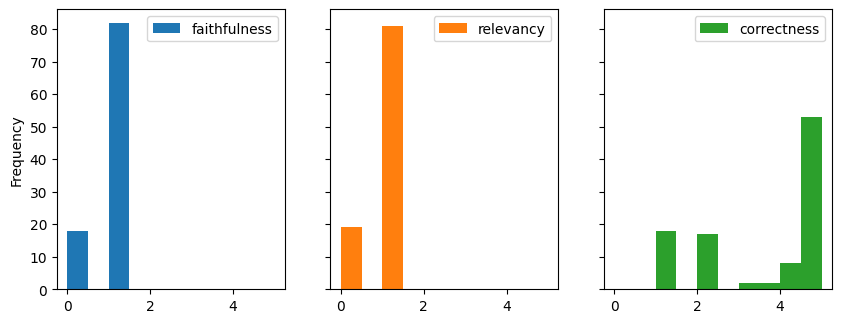

In [48]:

df_completo.plot(kind='hist', subplots=True, layout=(2, 3), figsize=(10, 8), sharey=True);


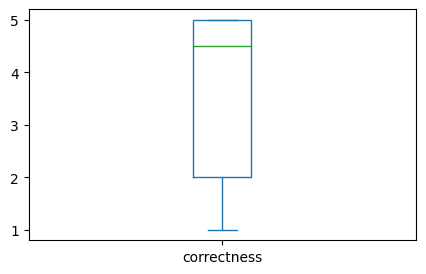

In [51]:
df_completo['correctness'].plot(kind='box', figsize=(5, 3));

In [52]:
df_completo['correctness'].value_counts()

correctness
5.0    30
4.5    23
1.0    18
2.0    17
4.0     8
3.0     2
3.5     2
Name: count, dtype: int64

In [57]:
df_completo['correctness'].describe()

count    100.000000
mean       3.505000
std        1.569107
min        1.000000
25%        2.000000
50%        4.500000
75%        5.000000
max        5.000000
Name: correctness, dtype: float64

In [63]:
from sklearn.preprocessing import MinMaxScaler

df_normalizado = df_completo.copy()


# Inicializar o MinMaxScaler
scaler = MinMaxScaler()

# Normalizar a coluna 'A'
df_normalizado['correctness_normalized'] = scaler.fit_transform(df_normalizado[['correctness']])

df_normalizado.describe()


,faithfulness,relevancy,correctness,correctness_normalized
count,100.000000,100.000000,100.000000,100.000000
mean,0.820000,0.810000,3.505000,0.626250
std,0.386123,0.394277,1.569107,0.392277
min,0.000000,0.000000,1.000000,0.000000
25%,1.000000,1.000000,2.000000,0.250000
50%,1.000000,1.000000,4.500000,0.875000
75%,1.000000,1.000000,5.000000,1.000000
max,1.000000,1.000000,5.000000,1.000000


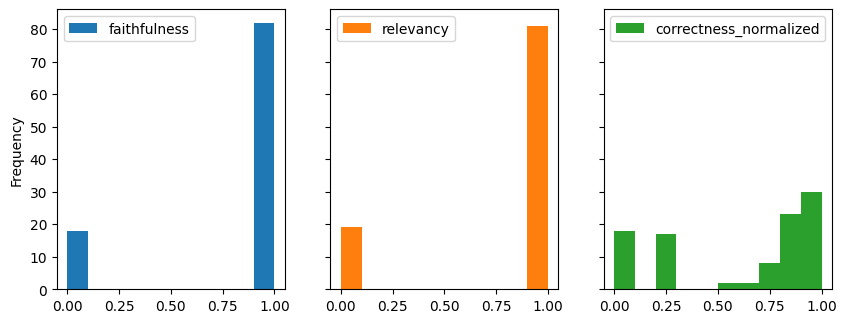

In [64]:
df_normalizado.drop(columns='correctness').plot(kind='hist', subplots=True, layout=(2, 3), figsize=(10, 8), sharey=True);
